In [1]:
from birdclef.utils import get_spark
import pyspark.sql.functions as F

In [2]:
spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/08 02:05:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet(
    "../../data/processed/birdclef-2023/consolidated_v3_sample"
)
df.show(n=5)

+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|species|track_stem|track_type|          track_name|           embedding|      prediction_vec|         predictions|start_time|             energy|
+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[0.75343722105026...|[-10.260432243347...|[{0, 2342, Phyllo...|        36|0.25369036197662354|
|refwar2|  XC128009|   source1|refwar2/XC128009_...|[0.19527475535869...|[-9.6245841979980...|[{0, 684, Cinclor...|        36| 20.364137649536133|
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[1.32953834533691...|[-13.427273750305...|[{0, 890, Culicic...|        69|0.18416672945022583|
|refwar2|  XC128009|  original|refwar2/XC128009.mp3|[1.89621150493621...|[-17.041515350341...|[{0, 185, Anthus ...|   

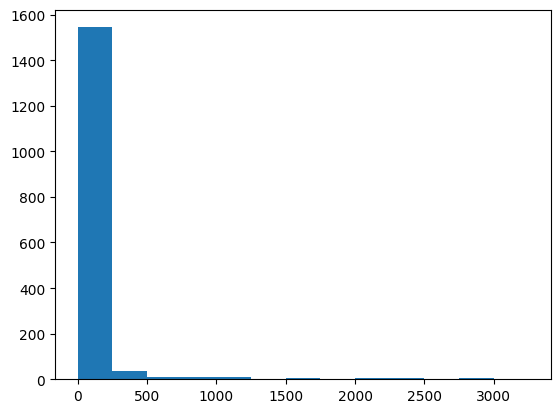

In [4]:
import matplotlib.pyplot as plt

energies = [x["energy"] for x in df.select("energy").collect()]

plt.hist(energies, bins=[250*x for x in range(14)])
plt.show()

Extract embeddings from source track only

In [5]:
# bird_call = df.filter(df["energy"] >= 250)
# bird_call.show()
# print(bird_call.count())

Exploded predictions

In [6]:
print(df.select(df.track_name).take(1)[0])

df.select(df.predictions).take(1)[0]["predictions"]

Row(track_name='malkin1/XC132986.mp3')


[Row(rank=0, index=2342, label='Phylloscopus trochiloides_Greenish Warbler', mapped_label='grewar3', probability=0.14227834343910217),
 Row(rank=1, index=1068, label='Ducula badia_Mountain Imperial-Pigeon', mapped_label='moipig1', probability=0.09622656553983688),
 Row(rank=2, index=1702, label='Macropygia ruficeps_Little Cuckoo-Dove', mapped_label='licdov1', probability=0.038490768522024155),
 Row(rank=3, index=359, label='Brachypteryx leucophris_Lesser Shortwing', mapped_label='lessho1', probability=0.018337246030569077),
 Row(rank=4, index=360, label='Brachypteryx montana_White-browed Shortwing', mapped_label='whbsho12', probability=0.006928994785994291),
 Row(rank=5, index=2335, label='Phylloscopus pulcher_Buff-barred Warbler', mapped_label='bubwar1', probability=0.005631797481328249),
 Row(rank=6, index=1588, label='Larvivora brunnea_Indian Blue Robin', mapped_label='inbrob1', probability=0.005230042617768049),
 Row(rank=7, index=890, label='Culicicapa ceylonensis_Gray-headed Cana

In [7]:
from pyspark.sql.functions import concat

explode_preds = df.select(
    "species",
    "track_stem",
    "track_name",
    "embedding",
    "start_time",
    "track_type",
    F.explode(df.predictions).alias("col"),
)
explode_preds = explode_preds.select(
    concat(explode_preds.track_name, explode_preds.start_time, explode_preds.track_type).alias("track_id"),
    "species",
    "embedding",
    explode_preds.col.label.alias("label"),
    explode_preds.col.mapped_label.alias("mapped_label"),
    explode_preds.col.probability.alias("probability"),
)
explode_preds.show()

# temp = source.select(source.track_name, f.explode(source.predictions))
# temp = temp.select(temp.track_name, temp.col["label"].alias("label"), temp.col["mapped_label"].alias("mapped_label"),
#                    temp.col["probability"].alias("probability"))
# temp.show()
# source.show()

+--------------------+-------+--------------------+--------------------+------------+--------------------+
|            track_id|species|           embedding|               label|mapped_label|         probability|
+--------------------+-------+--------------------+--------------------+------------+--------------------+
|malkin1/XC132986....|malkin1|[0.75343722105026...|Phylloscopus troc...|     grewar3| 0.14227834343910217|
|malkin1/XC132986....|malkin1|[0.75343722105026...|Ducula badia_Moun...|     moipig1| 0.09622656553983688|
|malkin1/XC132986....|malkin1|[0.75343722105026...|Macropygia rufice...|     licdov1|0.038490768522024155|
|malkin1/XC132986....|malkin1|[0.75343722105026...|Brachypteryx leuc...|     lessho1|0.018337246030569077|
|malkin1/XC132986....|malkin1|[0.75343722105026...|Brachypteryx mont...|    whbsho12|0.006928994785994291|
|malkin1/XC132986....|malkin1|[0.75343722105026...|Phylloscopus pulc...|     bubwar1|0.005631797481328249|
|malkin1/XC132986....|malkin1|[0.7534

Sigmoid

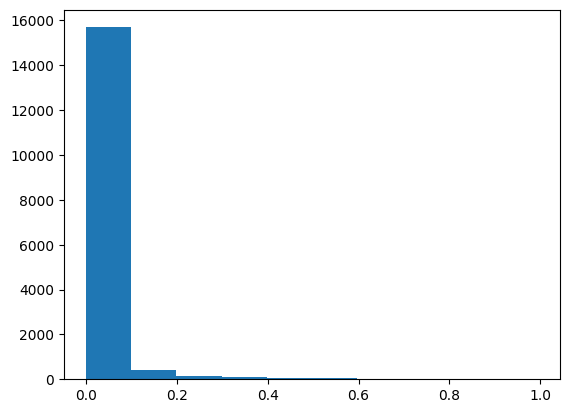

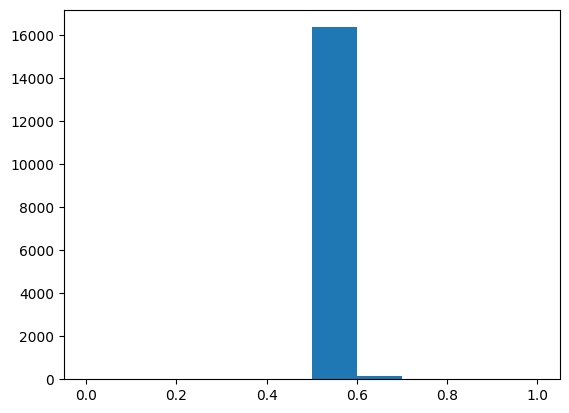

In [8]:
import matplotlib.pyplot as plt

explode_preds_sig = explode_preds.select(
    "species",
    "track_id",
    "embedding",
    "label",
    "mapped_label",
    (1 / (1 + F.exp(-1 * explode_preds.probability))).alias("probability"),
)
probs_no_sig = [x["probability"] for x in explode_preds.select("probability").collect()]
plt.hist(probs_no_sig)
plt.show()
probs = [x["probability"] for x in explode_preds_sig.select("probability").collect()]
x_axis = [i / 10 for i in range(10)]
plt.hist(probs, range=[0, 1])
plt.show()

Taking species with prob > 0.5

In [9]:
explode_preds_bird_calls = explode_preds.filter(explode_preds.probability > 0.5)
explode_preds_bird_calls.show()
print(explode_preds_bird_calls.count())

+--------------------+-------+--------------------+--------------------+------------+------------------+
|            track_id|species|           embedding|               label|mapped_label|       probability|
+--------------------+-------+--------------------+--------------------+------------+------------------+
|refwar2/XC596322_...|refwar2|[0.99149847030639...|Human vocal_Human...|      humvoc|0.6938544511795044|
|refwar2/XC525931_...|refwar2|[1.43871796131134...|Prinia sylvatica_...|     junpri1|0.8636960387229919|
|malkin1/XC369825_...|malkin1|[1.16651332378387...|Limnothlypis swai...|      swawar|0.5569329857826233|
|malkin1/XC574560....|malkin1|[1.23353230953216...|Cinnyris jugulari...|     olbsun4|0.6094335913658142|
|malkin1/XC132991....|malkin1|[1.14792478084564...|Phylloscopus orie...|     eabwar1|0.5228896737098694|
|bltapa1/XC289706_...|bltapa1|[0.71383780241012...|Xiphorhynchus sus...|     cocwoo1|0.8647496104240417|
|bltapa1/XC289706_...|bltapa1|[0.98918461799621...|Xiph

parsing species name

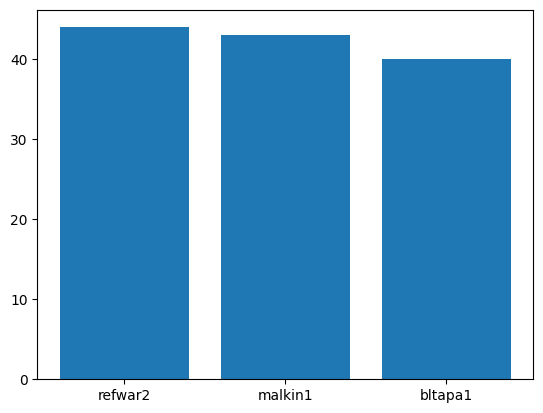

In [10]:
species = [s["species"] for s in explode_preds_bird_calls.select("species").collect()]
species_count = dict()
for s in species:
    species_count[s] = species_count.get(s, 0) + 1
plt.bar(list(species_count.keys()), list(species_count.values()))
plt.show()

final dataset

In [11]:
from pyspark.sql.functions import rand 

length = len(explode_preds_bird_calls.select("embedding").take(1)[0]["embedding"])

explode_preds_bird_calls = explode_preds_bird_calls.drop("probability")
explode_preds_bird_calls = explode_preds_bird_calls.dropDuplicates(["track_id"])
data = explode_preds_bird_calls.select(
    ["track_id", "species"]
    + [
        explode_preds_bird_calls.embedding[i].alias("embedding" + str(i))
        for i in range(length)
    ]
)
data = data.orderBy(rand())
data = data.toPandas()
print(len(data))
data.head()


23/05/08 02:05:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


121


,track_id,species,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,...,embedding310,embedding311,embedding312,embedding313,embedding314,embedding315,embedding316,embedding317,embedding318,embedding319
0,refwar2/XC128009_source2.mp387source2,refwar2,0.334503,1.117398,0.767471,0.169196,0.590562,1.129125,1.040234,0.613251,...,0.111500,0.757088,2.077208,1.318005,0.394392,0.341446,0.506529,0.301138,1.716311,1.200186
1,malkin1/XC369825_source0.mp30source0,malkin1,1.735671,0.849088,1.164086,0.643067,0.901944,1.153336,0.890980,0.578234,...,1.933536,0.265540,0.911633,1.167722,0.424585,1.107135,0.711796,0.381645,1.983452,0.076618
2,refwar2/XC128009.mp3105original,refwar2,1.581102,1.186679,0.970910,0.451714,0.953258,0.566743,0.854205,0.433167,...,1.018052,0.635094,0.964010,1.376136,1.570095,1.249430,1.038199,0.785575,1.379798,0.827938
3,refwar2/XC172869_source1.mp324source1,refwar2,1.244236,1.265282,0.594945,0.394637,0.891382,0.490170,0.143033,0.592258,...,0.547754,1.338107,0.662016,1.193642,0.567820,0.591769,0.402267,0.296385,0.508532,0.649239
4,malkin1/XC132990_source3.mp39source3,malkin1,0.468584,0.986242,0.578137,1.177194,0.052609,0.559234,0.851890,1.315775,...,1.002625,1.805893,1.510269,1.377753,1.093295,0.715333,1.249696,1.056978,2.164169,1.706610


classifier?

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_x, test_x, train_y, test_y = train_test_split(
    data.loc[:, (data.columns != "species") & (data.columns != "track_id")],
    data["species"],
    test_size=0.25,
    stratify=sorted(data["species"]),
)

def eval(truth, preds):
    print("Accuracy:", accuracy_score(truth, preds))
    print(
        "Precision:",
        precision_score(truth, preds, average=None),
        precision_score(truth, preds, average="macro"),
    )
    print(
        "Recall:",
        recall_score(truth, preds, average=None),
        recall_score(truth, preds, average="macro"),
    )
    print(
        "F1 Score:",
        f1_score(truth, preds, average=None),
        f1_score(truth, preds, average="macro"),
    )

In [22]:
from sklearn.tree import DecisionTreeClassifier

treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(train_x, train_y)
preds = treeClassifier.predict(test_x)

eval(test_y, preds)

Accuracy: 0.7419354838709677
Precision: [0.61538462 0.9        0.75      ] 0.7551282051282051
Recall: [1.         0.69230769 0.6       ] 0.764102564102564
F1 Score: [0.76190476 0.7826087  0.66666667] 0.7370600414078674


In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
preds = knn.predict(test_x)

eval(test_y, preds)

Accuracy: 0.8709677419354839
Precision: [0.8        0.90909091 0.9       ] 0.8696969696969696
Recall: [1.         0.76923077 0.9       ] 0.8897435897435897
F1 Score: [0.88888889 0.83333333 0.9       ] 0.8740740740740741


In [24]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000)
log.fit(train_x, train_y)
preds = log.predict(test_x)

eval(test_y, preds)

Accuracy: 0.9032258064516129
Precision: [0.72727273 1.         1.        ] 0.9090909090909092
Recall: [1.         0.76923077 1.        ] 0.923076923076923
F1 Score: [0.84210526 0.86956522 1.        ] 0.9038901601830664


In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_y)

xgbc = XGBClassifier()
xgbc.fit(train_x, le.transform(train_y))
preds = xgbc.predict(test_x)

eval(le.transform(test_y), preds)

Accuracy: 0.8387096774193549
Precision: [0.88888889 0.76923077 0.88888889] 0.849002849002849
Recall: [0.8        0.90909091 0.8       ] 0.8363636363636363
F1 Score: [0.84210526 0.83333333 0.84210526] 0.8391812865497076


In [17]:
print(xgbc.get_params())

{'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [25 * i for i in range(1, 10)],
}

search = GridSearchCV(
    estimator=xgbc, param_grid=params, scoring="precision_macro", n_jobs=-1, cv=2
)
search.fit(train_x, le.transform(train_y))
print(search.best_params_)
preds = search.predict(test_x)

eval(le.transform(test_y), preds)

{'n_estimators': 25}
Accuracy: 0.8387096774193549
Precision: [0.88888889 0.76923077 0.88888889] 0.849002849002849
Recall: [0.8        0.90909091 0.8       ] 0.8363636363636363
F1 Score: [0.84210526 0.83333333 0.84210526] 0.8391812865497076


In [20]:
import pickle

pickle.dump(log, open("../../data/models/baseline/logistic_reg_2.pkl", 'wb'), protocol=2)
pickle.dump(log, open("../../data/models/baseline/logistic_reg_3.pkl", 'wb'), protocol=3)

In [26]:
results = log.predict_proba(test_x)

In [55]:
import csv

f = open("../submission.csv", 'w')
writer = csv.writer(f)

header = ["row_id"]
for s in sorted(set(species)):
    header.append(f"{s}")
print(header)
writer.writerow(header)

avgs = {}
for i in range(len(results)):
    track = f"{data.iloc[i]['track_id'][:16]}"
    if track in avgs:
        running_avg = avgs[track][0]
        cnts = avgs[track][1]

        for j in range(len(sorted(set(species)))):
            running_avg[j] = (running_avg[j] * cnts[j] + results[i][j]) / (cnts[j] + 1)
            cnts[j] += 1
        
        avgs[track] = [running_avg, cnts]
    else:
        avgs[track] = []
        avgs[track].append([results[i][j] for j in range(len(sorted(set(species))))])
        avgs[track].append([1 for i in range(len(sorted(set(species))))])

for track in avgs.keys():
    line = [track]
    for i in range(len(sorted(set(species)))):
        line.append(f"{avgs[track][0][i]}")
    print(line)
    writer.writerow(line)


['row_id', 'bltapa1', 'malkin1', 'refwar2']
['refwar2/XC128009', '0.3201050732726942', '0.46411091301723956', '0.21578401371006617']
['malkin1/XC369825', '0.429722724123445', '0.39687049654065515', '0.17340677933589982']
['refwar2/XC172869', '0.4998566899964535', '0.423393649707582', '0.07674966029596457']
['malkin1/XC132990', '0.9602166471237034', '0.02444704172015978', '0.01533631115613665']
['bltapa1/XC552197', '0.0037034029885906912', '0.005827471656604093', '0.9904691253548052']
['bltapa1/XC753191', '0.9951207059838267', '0.0028247238959634878', '0.0020545701202098593']
['refwar2/XC596322', '0.25211716308010645', '0.012115448511429604', '0.7357673884084639']
['malkin1/XC371182', '0.38011469930897585', '0.12089583242547014', '0.498989468265554']
['refwar2/XC172812', '0.9767441658162263', '0.010150219120932493', '0.01310561506284119']
['malkin1/XC307594', '0.008676946774112935', '0.49771680875845026', '0.4936062444674369']
['bltapa1/XC289706', '0.35472780090663264', '0.4254019094607

In [34]:
print(log)

{'refwar2', 'malkin1', 'bltapa1'}
